### **Outline**

In this notebook, we study how to handle **large-scale datasets** in sklearn.

* In this course, so far we were able to load entire data in memory and were able to train and make inferences on all the data at once.

* The large scale data sets may not fit in memory and we need to devise strategies to handle it in the context of training and prediction use cases.

In this notebook, we will discuss the following topics :

* Overview of handling large-scale data.

* Incremental preprocessing and learning i.e. `fit()` vs `partial_fit()` : `partial_fit` is our friend in this cases.

* Combining preprocessing and incremental learning

## **Large-scale Machine Learning**

* Large-scale Machine Learning differs from traditional machine learning in the sense that it involves processing large amount of data in terms of its **size** or **number of samples, features or classes** 

* There were many exciting developements in efficient large scale learning on many real world use cases in the last decade.

* Although scikit-learn is optimized for **smaller data**, it does offer a decent set of **feature preprocessing** and **learning algorithms** for large scale data such as classification, regression and clustering.

* Scikit-learn handles large data through `partial_fit()` method instead of using the usual `fit()` method. 

The idea is to process data in **batches** and **update** the model parameters for each batch. This way of learning is referred to as **Incremental (or out-or-core) learning**.


### **Incremental Learning** 

Incremental learning may be required in the following two scenarios :

* For **out-of-memory (large) datasets** ,where it's not possible to **load the entire data into the RAM** at once, one can load the data in chunks and fit the training model for each chunk of data.

* For machine learning tasks where a new batch of data comes with time,re-training the model with the previous and new batch of data is a computationally expensive process.

Instead of re-training the model with the entire set of data, one can employ an incremental learning approach, where the model parameters are updated with the new batch of data.


### **Incremental Learning in `sklearn`**

To perform incremental learning, Scikit-learn implements `partial_fit` method that helps in training an out-of-memory dataset. 

In other words, it has the ability to learn incrementally from a batch of instances.

In this notebook, we will see an example of how to read, process, and train on such a large dataset that can't be loaded in memory entirely.

This method is expected to be called several times consecutively on different chunks of a dataset so as to implement out-of-core (online) learning. 

This function has some performance overhead, so it's recommended to call it on a considerable large batch of data(that fits into the memory), to overcome the limitation of overhead.


### **partial_fit() attributes :**

`partial_fit(X,y,[classes], [sample_weight])`

where,

* `X` : array of shape(n_samples, n_features) where **n_samples** is the number of samples & **n_features** is the number of features. 

* `y` : array of shape (n_samples,) of target values.

* `classes`: array of shape(n_classes,) containing a list of all the classes that can possibly appear in the y vector. Must be provided at the first call to partial_fit, can be omitted in subsequet calls.

* sample_`weight`: (optional) array of shape(n_samples,) containing weights applied to individual samples(1.for unweighted)

**Returns**: object(self) 



For classification tasks, we have to pass the list of possible target class labels in `classes` parameter to cope-up with the unseen target classes in the 1st batch of the data.

The following estimators implement partial_fit method :

* **Classification** :
  * MultinomialNB 

  * BernoulliNB 

  * SGDClassifier
  
  * Perceptron 

* **Regression** :
  * SGDRegressor


* **Clustering** :
  * `MiniBatchKmean`

`SGDRegressor` and `SGDClassifier` are commonly used for handling large data.

The problem with standard regression / classification implementations such as **batch gradient descent, support vector machines (SVMs), random forest** etc. is that because of the need to load all the data into memory at once, they can not be used in scenarios where we do not have sufficient memory. 

SGD, however, can deal with large data sets effectively by breaking up the data into chunks and processing them sequentially. 

The fact that we only need to load one chunk into memory at a time makes it useful for large-scale data as well as cases where we get streams of data at intervals.


### **fit() versus partial_fit()**

Below, we show the use of `partial_fit()` along with `SGDClassifier`.

For the purpose of illustration, we first use traditional `fit()` and then use `partial_fit()` on the same data.

### **Importing Libraries**

In [1]:
# Importing Libraries

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report ,ConfusionMatrixDisplay

import warnings 
warnings.filterwarnings('ignore')

### **Traditional Approach [using fit()]**

**Sample dataset**

We will use a synthetic classification dataset for demonstration.
Let us have 50000 samples with 10 features matrix. 

Further, lets have 3 classes in the target label, each class having a single cluster.

In [2]:
X, y = make_classification(n_samples=50000, n_features=10,
                           n_classes=3,
                           n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

We will make use of `SGDClassifier` to learn the classification model.

In [3]:
clf1 = SGDClassifier(max_iter=1000, tol=0.01)

We will use traditional `fit()` method to train out model. 

In [4]:
clf1.fit(X_train, y_train)

SGDClassifier(tol=0.01)

Let's obtain the training and test scores on the trained model.

In [5]:
train_score = clf1.score(X_train, y_train)
train_score

0.9223764705882352

In [6]:
test_score = clf1.score(X_test, y_test)
test_score

0.9224

We obtain the confusion matrix and classification report for evaluating the classifier.

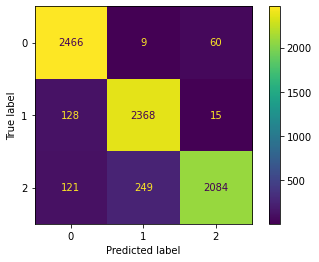

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf1.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2535
           1       0.90      0.94      0.92      2511
           2       0.97      0.85      0.90      2454

    accuracy                           0.92      7500
   macro avg       0.93      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500



### **Incremental Approach [using partial_fit()]**

We will now assume that the data can't be kept completely in the main memory and hence, will load chunks of data and fit usng `partial_fit()`.

In [9]:
X_train[:5]

array([[-2.29159844,  0.02091326,  0.83692475,  0.40334635, -0.85712345,
         0.10922827,  0.12431572,  2.28815044,  0.08941231,  1.3970629 ],
       [ 0.92861135,  0.70557977,  0.04412851,  0.72054533,  0.09660703,
         0.30020664,  2.11156696, -1.11936906, -0.44856979,  0.01935755],
       [-0.19039778, -0.45235961, -0.64982729,  0.34137055, -0.34691607,
         0.21451974, -0.44904781,  0.55076812,  0.78134819,  0.33105366],
       [ 1.1583492 ,  0.49090667,  1.06375715, -0.51689404,  1.1209298 ,
        -0.27734821,  0.64698903, -1.90202329, -1.64475696, -0.78198161],
       [ 0.97511431, -0.58098048,  0.21484446, -0.07367407,  1.17026029,
         0.09359779,  0.77655646, -1.25990625, -0.65231873,  0.17549224]])

In [10]:
y_train[:5]

array([2, 1, 0, 1, 1])

In order to load data chunk, we will first store the given (training) data in a CSV file.

This is just for demonstration purpose. In a real-case scenario, the large dataset might already be in the form of say, a CSV file which we will be reading in multiple iterations.

In [11]:
train_data = np.concatenate((X_train, y_train[:,np.newaxis]), axis=1)
train_data[:5]

array([[-2.29159844,  0.02091326,  0.83692475,  0.40334635, -0.85712345,
         0.10922827,  0.12431572,  2.28815044,  0.08941231,  1.3970629 ,
         2.        ],
       [ 0.92861135,  0.70557977,  0.04412851,  0.72054533,  0.09660703,
         0.30020664,  2.11156696, -1.11936906, -0.44856979,  0.01935755,
         1.        ],
       [-0.19039778, -0.45235961, -0.64982729,  0.34137055, -0.34691607,
         0.21451974, -0.44904781,  0.55076812,  0.78134819,  0.33105366,
         0.        ],
       [ 1.1583492 ,  0.49090667,  1.06375715, -0.51689404,  1.1209298 ,
        -0.27734821,  0.64698903, -1.90202329, -1.64475696, -0.78198161,
         1.        ],
       [ 0.97511431, -0.58098048,  0.21484446, -0.07367407,  1.17026029,
         0.09359779,  0.77655646, -1.25990625, -0.65231873,  0.17549224,
         1.        ]])

In [12]:
a = np.asarray(train_data) 
np.savetxt('train_data.csv',a, delimiter=',')

Now, our data for demonstration is ready in a csv file.

Let's create `SGDClassifier` object that we intend to train with `partial_fit()`.

In [13]:
clf2 = SGDClassifier(max_iter=1000, tol=0.01)

#### **Processing data chunk by chunk**

* Pandas' read_csv() function has an attribute `chunksize` that can be used to read data chunk by chunk. 

* The `chunksize` parameter specifies the number of rows per chunk. (The last chunk may contain fewer than chunksize rows, of course.) 

* We can then use this data for `partial_fit()`. 

* We can then repeat these two steps multiple times. That way entire data may not be required to be kept in memmory.

In [14]:
import pandas as pd

chunksize = 1000 
iter = 1 

for train_df in pd.read_csv('train_data.csv', chunksize=chunksize, iterator=True):
    # print(train_data.shape)
    if iter ==1:
        # print(train_df)
        # In the first iteration, we are specifying all possible class labels.
        X_train_partial = train_df.iloc[:,0:10]
        y_train_partial = train_df.iloc[:,10]

        clf2.partial_fit(X_train_partial,y_train_partial,
                        classes=np.array([0,1,2])) 
    
    else:
        X_train_partial = train_df.iloc[:,0:10]
        y_train_partial = train_df.iloc[:,10]

        clf2.partial_fit(X_train_partial,y_train_partial) 
    
    print("After iter # : ", iter) 
    print(clf2.coef_) 
    print()
    print(clf2.intercept_) 
    print('-'*30)
    iter+=1 

After iter # :  1
[[ 19.38830885  -9.8407469  -45.97717728  -5.87280243   0.42674605
    6.21765462   3.55850528   0.1417346   41.08967472 -13.94867119]
 [ 12.92169609  15.81072392  18.0450216   -9.00425388  12.78754988
   18.86647869   9.1221019  -24.31521829 -24.99480569 -14.25634197]
 [-29.47922706   8.40986526  24.23256001  13.41447864   1.94339806
   -3.96856641  -2.62356224  22.68345616 -13.33739481  14.6376807 ]]

[-59.03986614 -74.98556842  -6.04887573]
------------------------------
After iter # :  2
[[ -0.43318992  -1.0332125  -33.40136516   0.25054696   3.98749852
   -1.00136424   2.54789093  17.25781737  36.12161057   2.72497412]
 [ 22.4240924    1.12713107   2.65918168   3.41619314   2.26348056
   10.95051098 -12.5037477  -27.82945064 -12.54647862  12.96506279]
 [-18.262215    -1.03959563  15.93677646  -5.23414935   8.99892245
    3.27627136   4.47310495  13.58859847  -9.25742246   0.18387247]]

[-50.34539254 -50.4647003   -4.39114887]
------------------------------
After 

**Note :**

* In the first call to `partial_fit()`, we passed the list of possible target class labels. For subsequent calls to `partial_fit()`, this is not required.

* Observe the changing values of the classifier attributes : `coef_` and `intercept_` which we are printing in each iteration.

In [15]:
test_score = clf2.score(X_test ,y_test)
test_score

0.8964

Let's evaluate the classifier by examining the `confusion_matrix`.

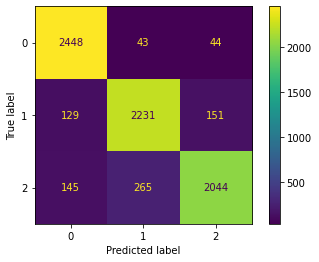

In [16]:
y_pred = clf2.predict(X_test) 

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.show()

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2535
           1       0.88      0.89      0.88      2511
           2       0.91      0.83      0.87      2454

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500



Apart from `SGDClassifier`, we can also train `Perceptron()`, `MultinomialNB()`, in a similar manner.

### **CountVectorizer vs HashingVectorizer**

Vectorizers are used to convert a collection of text documents to a vector representation, thus helping in preprocessing them before applying any model on these text documents.

`CountVectorizer` and `HashingVectorizer` both perform the task of vectorizing the text documents. However, there are some differences among them.

* One difference is that `HashingVectorizer` does not store the resulting vocabulary (i.e. the unique tokens). Hence, it can be used to learn from data that does not fit into the computer's main memory. 

* Each mini-batch is vectorized using `HashingVectorizer` so as to guarantee that the input space of the estimator has always the same dimensionality.

* With `HashingVectorizer`, each token directly maps to a pre-defined column position in a matrix. 

* For example, if there are 100 columns in the resultant (vectorized) matrix, each token (word) maps to 1 of the 100 columns. The mapping between the word and the position in matrix is done using hashing.

* In other words in `HashingVectorizer`, each token transforms to a column position instead of adding to the vocabulary. 

Not storing the vocabulary is useful while handling large datasets. This is because holding a huge token vocabulary compromising of millions of words may be a challenging when the memory is limited.

Since `HashingVectorizer` does not store vocabulary , its object not only takes lesser space, it also alleviates any dependence with function calls performed on the previous chunk of data in case of incremental learning.

Let us take some sample text documents and vectorize them, first using **CountVectorizer** and then **HashingVectorizer**.

In [18]:
text_documents = ['The well-known saying an apple a day keeps the doctor away has a very straightforward, literal meaning, that the eating of fruit maintains good health.',
'The proverb fist appeared in print in 1866 and over 150 years later is advice that we still pass down through generation.',
'British apples are one of the nations best loved fruit and according to Great British Apples, we consume around 122,000 tonnes of them each year.',
'But what are the health benefits, and do they really keep the doctor away?']


#### **1. CountVectorizer**

We will first import the library and then create an object of CountVectorizer class.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

We will now use this object to vectorize the input text documents using the function `fit_transform()`.

In [20]:
X_c = count_vectorizer.fit_transform(text_documents)

In [21]:
X_c.shape

(4, 66)

Here, **66** is the **size of the vocabulary**.

We can also see the vocabulary using `vocabulary_` attribute.

In [22]:
count_vectorizer.vocabulary_

{'the': 54,
 'well': 62,
 'known': 36,
 'saying': 50,
 'an': 6,
 'apple': 9,
 'day': 19,
 'keeps': 35,
 'doctor': 21,
 'away': 13,
 'has': 30,
 'very': 60,
 'straightforward': 52,
 'literal': 38,
 'meaning': 41,
 'that': 53,
 'eating': 24,
 'of': 43,
 'fruit': 26,
 'maintains': 40,
 'good': 28,
 'health': 31,
 'proverb': 48,
 'fist': 25,
 'appeared': 8,
 'in': 32,
 'print': 47,
 '1866': 3,
 'and': 7,
 'over': 45,
 '150': 2,
 'years': 65,
 'later': 37,
 'is': 33,
 'advice': 5,
 'we': 61,
 'still': 51,
 'pass': 46,
 'down': 22,
 'through': 57,
 'generation': 27,
 'british': 16,
 'apples': 10,
 'are': 11,
 'one': 44,
 'nations': 42,
 'best': 15,
 'loved': 39,
 'according': 4,
 'to': 58,
 'great': 29,
 'consume': 18,
 'around': 12,
 '122': 1,
 '000': 0,
 'tonnes': 59,
 'them': 55,
 'each': 23,
 'year': 64,
 'but': 17,
 'what': 63,
 'benefits': 14,
 'do': 20,
 'they': 56,
 'really': 49,
 'keep': 34}

And **4** is the **number of text documents**. 

Following is the representation of four text documents :

In [23]:
print(X_c)

  (0, 54)	3
  (0, 62)	1
  (0, 36)	1
  (0, 50)	1
  (0, 6)	1
  (0, 9)	1
  (0, 19)	1
  (0, 35)	1
  (0, 21)	1
  (0, 13)	1
  (0, 30)	1
  (0, 60)	1
  (0, 52)	1
  (0, 38)	1
  (0, 41)	1
  (0, 53)	1
  (0, 24)	1
  (0, 43)	1
  (0, 26)	1
  (0, 40)	1
  (0, 28)	1
  (0, 31)	1
  (1, 54)	1
  (1, 53)	1
  (1, 48)	1
  :	:
  (2, 39)	1
  (2, 4)	1
  (2, 58)	1
  (2, 29)	1
  (2, 18)	1
  (2, 12)	1
  (2, 1)	1
  (2, 0)	1
  (2, 59)	1
  (2, 55)	1
  (2, 23)	1
  (2, 64)	1
  (3, 54)	2
  (3, 21)	1
  (3, 13)	1
  (3, 31)	1
  (3, 7)	1
  (3, 11)	1
  (3, 17)	1
  (3, 63)	1
  (3, 14)	1
  (3, 20)	1
  (3, 56)	1
  (3, 49)	1
  (3, 34)	1


#### **2. HashingVectorizer**

Let us now see how `HashingVectorizer` is different from `CountVectorizer`.

We will create an object of `HashingVectorizer`. While creating the object, we need to specify the number of features we wish to have in the feature matrix.

In [24]:
from sklearn.feature_extraction.text import HashingVectorizer
hashing_vectorizer = HashingVectorizer(n_features=50)

An important parameter of `HashingVectorizer` class is `n_features`. It declares the number of features (columns) in the output feature matrix.

**NOTE :** Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

Let's perform hashing vectorization with `fit_transform`.

In [25]:
X_h = hashing_vectorizer.fit_transform(text_documents)

Let us examine the shape of the transformed feature matrix. The number of columns in this matrix is equal to the `n_features` attribute we specified.

In [26]:
X_h.shape

(4, 50)

Following is the representation of the four text documents :

In [27]:
print(X_h[0])

  (0, 5)	0.0
  (0, 8)	-0.47140452079103173
  (0, 10)	-0.23570226039551587
  (0, 11)	-0.23570226039551587
  (0, 13)	0.0
  (0, 18)	-0.23570226039551587
  (0, 20)	0.23570226039551587
  (0, 26)	0.0
  (0, 29)	0.23570226039551587
  (0, 33)	0.23570226039551587
  (0, 36)	-0.23570226039551587
  (0, 38)	0.47140452079103173
  (0, 39)	-0.23570226039551587
  (0, 45)	-0.23570226039551587
  (0, 46)	0.23570226039551587


**IMP :**

Overall, `HashingVectorizer` is a good choice if we are falling short of memory and resources, or we need to perform incremental learning. 

However, `CountVectorizer` is a good choice if we need to access the actual tokens.

### **Demonstration**

#### **1. Downloading the dataset**

We download a dataset from UCI ML datasets's library.

Instead of downloading, unzipping and then reading, we are directly reading the zipped csv file. 

For that purpose, we are making use of `urllib.request`, `BytesIO` and `TextIOWrapper` classes.

This is a sentiment analysis dataset. There are only two columns in the dataset. One for the textual review and the other for the sentiment.

In [28]:
from io import StringIO, BytesIO, TextIOWrapper 
from zipfile import ZipFile 
import urllib.request

In [29]:
resp = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip')

zipfile = ZipFile(BytesIO(resp.read()))

data = TextIOWrapper(zipfile.open('sentiment labelled sentences/amazon_cells_labelled.txt'),encoding='utf-8') 

In [30]:
df = pd.read_csv(data, sep='\t') 
df.columns = ['review','sentiment']

#### **2. Exploring the dataset**

In [31]:
df.head()

,review,sentiment
0,"Good case, Excellent value.",1
1,Great for the jawbone.,1
2,Tied to charger for conversations lasting more...,0
3,The mic is great.,1
4,I have to jiggle the plug to get it to line up...,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     999 non-null    object
 1   sentiment  999 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


In [33]:
df.describe()

,sentiment
count,999.000000
mean,0.500501
std,0.500250
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


As we can see, 

* There are 999 samples in the dataset.

* The possible classes for sentiment are 1 and 0.


#### **3. Splitting data into train and test**

In [34]:
X = df.loc[:,'review']
# X2 = df.iloc[:,0]

y = df.loc[:,'sentiment'] 

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((799,), (200,), (799,), (200,))

#### **4. Preprocessing**

In [37]:
from sklearn.feature_extraction.text import HashingVectorizer 
vectorizer = HashingVectorizer()

#### **5. Creating an instance of the SGDClassifier**

In [38]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(penalty='l2', loss='hinge')

#### **6. Iteration 1 of partial_fit()**

* We will assume we do not have sufficient memory to handle all the 799 samples in one go for training purpose. 

* So, we will take the first 400 samples from the training data and `partial_fit()` our classifier.

* Another use case of `partial_fit` here could also be a scenario where we only have 400 samples available at a time. So, we fit our classifier with them. 

* However, we `partial_fit` it, to have the possibility of traning it with more data later whenever that becomes available.

In [39]:
X_train_part1_hashed = vectorizer.fit_transform(X_train[0:400])
y_train_part1 = y_train[0:400]

In [40]:
# we need to mention all classes in the first iteration of partial_fit()
all_classes = np.unique(df.loc[:, 'sentiment'])

In [41]:
classifier.partial_fit(X_train_part1_hashed,
                       y_train_part1, classes=all_classes)

SGDClassifier()

Let us now use this classifier on our test data that we had kept aside earlier.

In [42]:
# first we will have to preprocess the X_test with the same vectorizer that was fit on the train data.
X_test_hashed = vectorizer.transform(X_test)

In [43]:
test_score = classifier.score(X_test_hashed, y_test)
print('Test score : ', test_score)

Test score :  0.71


**Note :**
We can also store this classifier using pickle object and can access it later.

#### **7. Iteration 2 of partial_fit()**

We will now assume that more data became available. So, we will fit the same  classifier with more data and observe if our test score improves.

In [44]:
X_train_part2_hashed = vectorizer.fit_transform(X_train[400:])
y_train_part2 = y_train[400:]

In [45]:
classifier.partial_fit(X_train_part2_hashed, y_train_part2)

SGDClassifier()

In [46]:
test_score = classifier.score(X_test_hashed, y_test)
print('Test score : ', test_score)

Test score :  0.74


We see that our test score has improved after we fed more data to the classifier in the second iteration of `partial_fit()`.